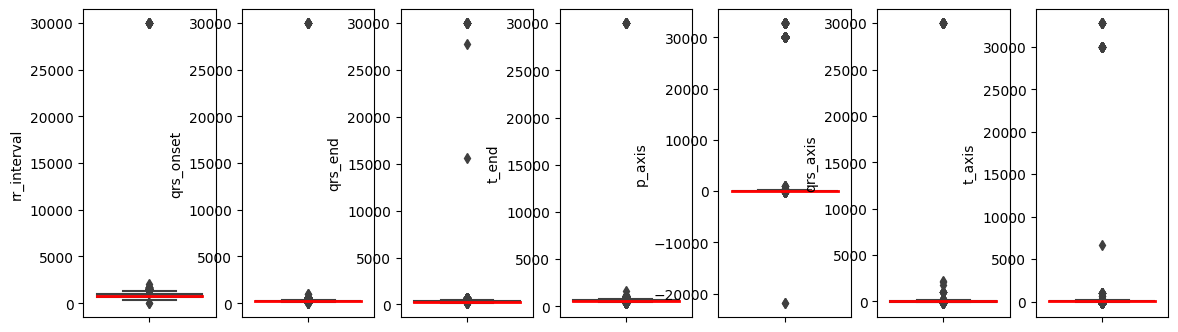

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1. Load the dataset (replace with your actual CSV path)
df = pd.read_csv('module_2.csv')

# 2. Select columns of interest (all should be strictly positive if using a log scale)
features = ['rr_interval', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']

df_boxplot = df[features]

n = df_boxplot.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = df_boxplot.columns[i]
    sns.boxplot(y = df_boxplot.iloc[:,i],data=df_boxplot, medianprops={"color": "r", "linewidth": 2})

# Выводы: есть выбросы

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

df = pd.read_csv('module_2.csv')

#  A) Remove outliers in certain numeric columns
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = df[(df[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[
    (full_df_filtered['p_onset'] < full_df_filtered['p_end']) &
    (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])
]

#  B) Merge all textual reports into one column
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = (
    full_df_filtered[reports]
    .astype(str)
    .agg(' '.join, axis=1)
)
full_df_filtered['report_0'] = (
    full_df_filtered['report_0']
    .str.replace(r'\bnan\b', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

#  C) Rename columns 'eeg_time ', 'eeg_date ' => 'eeg_time', 'eeg_date'
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})

#  D) Drop columns bandwidth, filtering
full_df_filtered = full_df_filtered.drop(columns=['bandwidth', 'filtering'])

#  E) Move 'Healthy_Status' to the far right
full_df_filtered = full_df_filtered[
    [col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']
]

#  F) Tokenize 'report' column
words = [text.split() for text in full_df_filtered['report']]

#  G) Train a Word2Vec model
w2v_model = Word2Vec(words)

#  H) Convert each 'report' to the mean embedding => single float
def get_sentence_embedding(sentence):
    tokens = sentence.split()
    word_vectors = [w2v_model.wv[tok] for tok in tokens if tok in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(w2v_model.vector_size)

full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

# Final result
print("\n=== Final DataFrame after snippet ===")
display(full_df_filtered)


=== Final DataFrame after snippet ===


,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.034539,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.034539,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,0.003658,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.010358,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.010358,952,40,146,198,282,598,24,80,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,15837443,40,40125246,6602038,8:39 AM,04.04.2016,0.010358,769,40,166,214,302,592,55,60,68,1
9995,19612562,29,40125255,6752764,11:26 AM,12.04.2016,0.010358,606,40,162,204,298,526,64,68,66,1
9996,14816795,1,40125256,6555070,6:01 PM,12.04.2016,0.010358,606,40,160,202,294,534,70,73,66,1
9998,13871862,2,40125273,6848296,5:38 PM,03.01.2011,0.010358,789,40,158,192,288,592,43,14,15,1


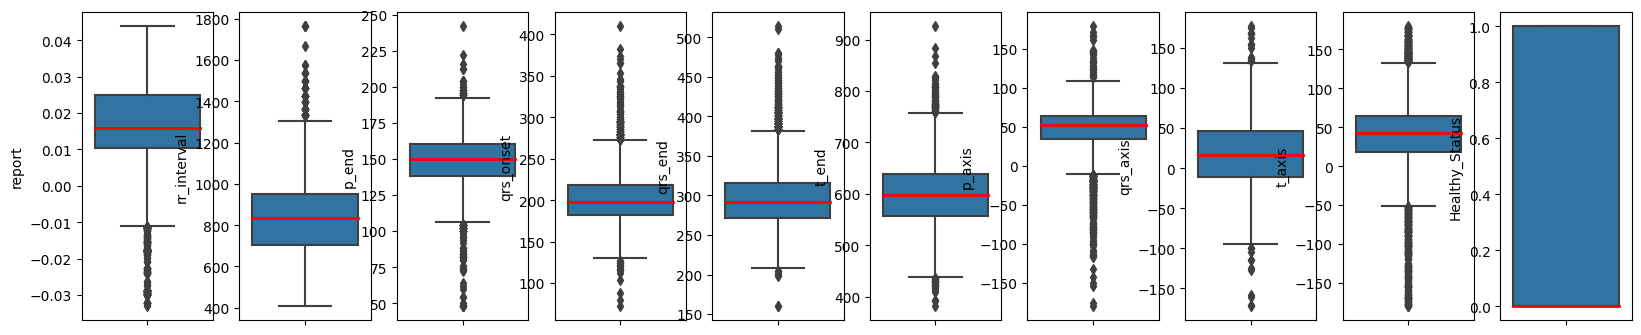

In [4]:
table_data = full_df_filtered[['report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data.head()


n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data, medianprops={"color": "r", "linewidth": 2})

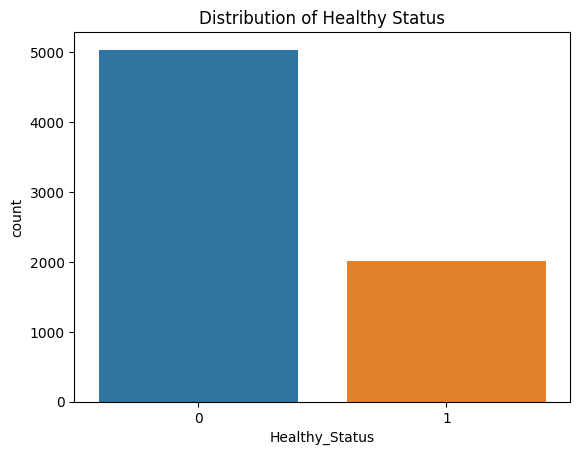

In [5]:
sns.countplot(data=table_data, x="Healthy_Status")
plt.title("Distribution of Healthy Status")
plt.show()

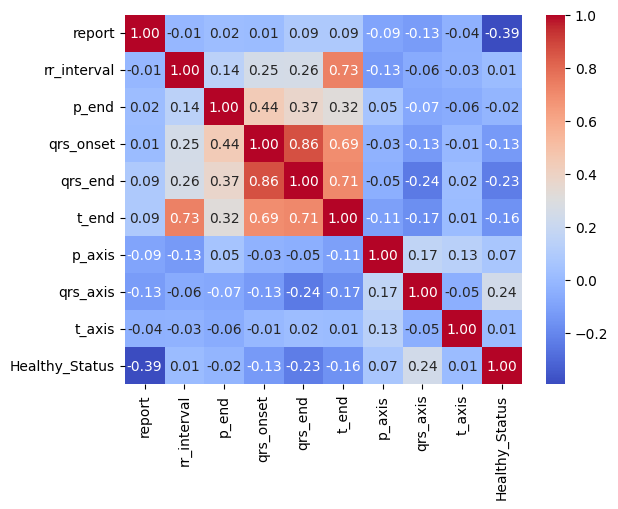

In [6]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

`qrs_onset` и `qrs_end`: высокая положительная корреляция (~0,86). Очевидно, так как это время начала и окончания QRS.

`qrs_onset` и `t_end` также показывают значительную корреляцию (~0,69). Задержка начала QRS часто сопровождает задержку завершения зубца T в одном и том же сердечном сокращении.

`t_end` против `rr_interval`: корреляция около ~0,73 предполагает, что субъекты с более длинными интервалами RR (т. е. более медленным ритмом сердца) также склонны иметь дольшое время T-волны

<Axes: xlabel='rr_interval', ylabel='t_end'>

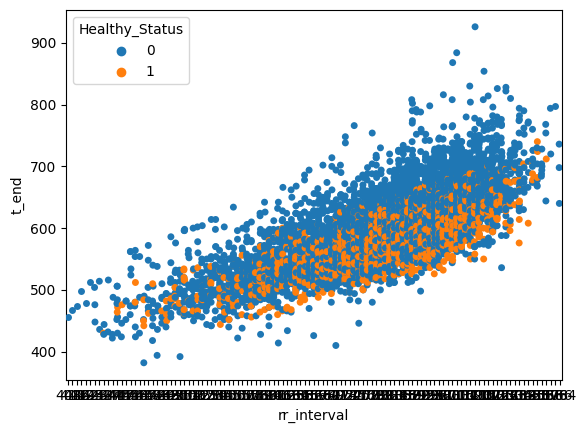

In [8]:
sns.stripplot(x=table_data['rr_interval'],y=table_data['t_end'],
              hue=table_data['Healthy_Status'],jitter=True)